# Monte-Carlo Method

## Install External Libraries

In [0]:
!pip install PyPortfolioOpt
!pip install yfinance

## Import Dependencies

In [0]:
import matplotlib
import pypfopt
import datetime
import math

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Set Local Variables

In [0]:
risk_free_rate = 0.06501 # Risk-free rate of return, 10Yr Treasury Bond Yield
trading_days = 240 # No of trading days in a year

start_date = datetime.date(2000, 1, 1) # Oldest date to be considered for price analysis
investment_date = datetime.date(2019, 1, 1) # Date when funds are invested 
investment_end = datetime.date(2020, 5, 1) # Date of end of investment period

In [0]:
asset_universe = ['HDFC.BO', 'BAJFINANCE.BO', 'SBIN.BO', 'TITAN.BO', 'HDFCBANK.BO', 
                  'HEROMOTOCO.BO', 'INFY.BO', 'KOTAKBANK.BO', 'ONGC.BO', 'RELIANCE.BO',
                  'TATASTEEL.BO', 'LT.BO', 'M&M.BO', 'HINDUNILVR.BO', 'NESTLEIND.BO',
                  'ASIANPAINT.BO', 'ITC.BO', 'SUNPHARMA.BO', 'ICICIBANK.BO', 'INDUSINDBK.BO',
                  'AXISBANK.BO', 'HCLTECH.BO', 'BHARTIARTL.BO', 'MARUTI.BO','ULTRACEMCO.BO',
                  'TCS.BO', 'NTPC.BO', 'TECHM.BO', 'POWERGRID.BO','BAJAJ-AUTO.BO'
]

## Process Historical Data

In [0]:
# Download historical closing prices
sensex30_history = yf.download(asset_universe, start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']
sensex_history = yf.download('^BSESN', start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
# Rename data columns
rename_col_dict = dict()
for ticker in sensex30_history.columns:
  rename_col_dict[ticker] = ticker[:-3]

sensex30_history = sensex30_history.rename(columns=rename_col_dict)

## Compute and Plot Expected Returns

In [0]:
# Compute expected returns
sensex30_prices = sensex30_history.loc[start_date:investment_date , :].copy()

# Compute annualised mean daily returns of 30 stocks using data since 2009
mean_daily_returns = sensex30_prices.pct_change().dropna(how="all").mean()

# Annualise mean daily returns via compounding
expected_returns = (1 + mean_daily_returns) ** trading_days - 1
# print(type(expected_returns))

In [0]:
# Plot Expected Returns
plt.style.use("seaborn-whitegrid")
ax = expected_returns.plot(kind="barh")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 0.5))
plt.grid(True)
plt.ylabel("Stock Tickers")
plt.xlabel("Expected Return")
plt.show()

## Compute and Plot Co-variance Matrix

In [0]:
# Compute Covariance Matrix
cov_matrix = pypfopt.risk_models.CovarianceShrinkage(sensex30_prices, frequency=trading_days).ledoit_wolf(shrinkage_target="constant_correlation")

# Convert Covariance Matrix to Correlation Matrix
inv_diag = np.diag(1 / np.sqrt(np.diag(cov_matrix)))
corr_matrix = pd.DataFrame(np.dot(inv_diag, np.dot(cov_matrix, inv_diag)), index=cov_matrix.index, columns=cov_matrix.columns)

In [0]:
# Plot Covariance Matrix Heatmap

plt.style.use("default")
fig, ax = plt.subplots()

corr_ax = ax.imshow(corr_matrix, cmap='magma')

fig.colorbar(corr_ax)
ax.set_xticks(np.arange(0, corr_matrix.shape[0], 1))
ax.set_xticklabels(corr_matrix.index)
ax.set_yticks(np.arange(0, corr_matrix.shape[0], 1))
ax.set_yticklabels(corr_matrix.index)
plt.xticks(rotation=90)

plt.show()

## Monte-Carlo Simulations

In [0]:
num_iterations = 1000000 # Number of simulations to be run
simulation_results = np.zeros((33 , num_iterations)) # Array to store the simulation results

In [0]:
# Simulate random weights and normalize them to ensure their aggregate is 1

for i in range(num_iterations):
    weights = np.array(np.random.random(30))
    weights /= np.sum(weights)
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
    simulation_results[0,i] = portfolio_return
    simulation_results[1,i] = portfolio_stddev
    simulation_results[2,i] = simulation_results[0,i] / simulation_results[1,i]
    for j in range(len(weights)):
      simulation_results[j+3,i] = weights[j]

In [0]:
stock_list = list(sensex30_history.columns)
columns = ['return','stdev','sharpe'] + stock_list

simulation_df = pd.DataFrame(simulation_results.T, columns=columns)

## Optimal Portfolio: Maximum Sharpe Ratio

In [0]:
max_sharpe_portfolio = simulation_df.iloc[simulation_df['sharpe'].idxmax()]

max_sharpe_nonzero_wts = dict()
for key, val in max_sharpe_portfolio.iloc[3:].items():
  if val != 0:
    max_sharpe_nonzero_wts[key] = val
print(max_sharpe_nonzero_wts)

# max_sharpe_nonzero_wts = {'ASIANPAINT': 0.07343238490348997, 'AXISBANK': 0.008612974885070648, 'BAJAJ-AUTO': 0.03813084499118751, 'BAJFINANCE': 0.061185912560794316, 'BHARTIARTL': 0.004593054770775295, 'HCLTECH': 0.02086067944574963, 'HDFC': 0.03605937751872655, 'HDFCBANK': 0.040425363142332506, 'HEROMOTOCO': 0.06362023999177947, 'HINDUNILVR': 0.0013520625386036853, 'ICICIBANK': 0.043585316890703024, 'INDUSINDBK': 0.004503803481489264, 'INFY': 0.08042114124561395, 'ITC': 0.053653646551070425, 'KOTAKBANK': 0.024905588185587458, 'LT': 0.00534836152674258, 'M&M': 0.02682813480887665, 'MARUTI': 0.002167708621866709, 'NESTLEIND': 0.06076848889180933, 'NTPC': 0.015182944531474951, 'ONGC': 0.05442929888657013, 'POWERGRID': 0.03257005691129782, 'RELIANCE': 0.015565039461076551, 'SBIN': 0.05649540175373632, 'SUNPHARMA': 0.04901544405907509, 'TATASTEEL': 0.007102437112315602, 'TCS': 0.06347439598854171, 'TECHM': 0.024771014628683825, 'TITAN': 0.0016933222736356726, 'ULTRACEMCO': 0.02924555944132324}

In [0]:
# Plot Maximum Sharpe Ratio Portfolio

plt.style.use("default")
plt.pie(max_sharpe_nonzero_wts.values(), labels=max_sharpe_nonzero_wts.keys(), autopct="%.2f%%", pctdistance=0.8)
plt.show()

## Optimal Portfolio: Min Volatility

In [0]:
min_volatility_portfolio = simulation_df.iloc[simulation_df['stdev'].idxmin()]

min_volatility_nonzero_wts = dict()
for key, val in min_volatility_portfolio.iloc[3:].items():
  if val != 0:
    min_volatility_nonzero_wts[key] = val
print(min_volatility_nonzero_wts)

# min_volatility_nonzero_wts = {'ASIANPAINT': 0.01965804063580751, 'AXISBANK': 0.07921900481905146, 'BAJAJ-AUTO': 0.04732795120160519, 'BAJFINANCE': 0.006120193243540219, 'BHARTIARTL': 0.06385857271334033, 'HCLTECH': 0.020179076198290534, 'HDFC': 0.020976476571361927, 'HDFCBANK': 0.0031102360667119348, 'HEROMOTOCO': 0.06424486152873407, 'HINDUNILVR': 0.0835648551821641, 'ICICIBANK': 0.02450419620045124, 'INDUSINDBK': 0.0023788405507441305, 'INFY': 0.0349505328171844, 'ITC': 0.005338397125845731, 'KOTAKBANK': 0.015183855668722742, 'LT': 0.02607057640222921, 'M&M': 0.007845254228140591, 'MARUTI': 0.04593207681819233, 'NESTLEIND': 0.051963769101888095, 'NTPC': 0.04613073193245974, 'ONGC': 0.016806068861266624, 'POWERGRID': 0.04827795057037961, 'RELIANCE': 0.06797010969697301, 'SBIN': 0.01728353751669665, 'SUNPHARMA': 0.06417051300273635, 'TATASTEEL': 0.010970783283510551, 'TCS': 0.008782654701519997, 'TECHM': 0.02575905660883659, 'TITAN': 0.00041541287572671064, 'ULTRACEMCO': 0.0710064138758882}

In [0]:
# Plot Minimum Volatility Ratio Portfolio

plt.style.use("default")
plt.pie(min_volatility_nonzero_wts.values(), labels=min_volatility_nonzero_wts.keys(), autopct="%.2f%%", pctdistance=0.8)
plt.show()

## Scatter Plot For Simulated Portfolios

In [0]:
# Plot Scatter Plot For Monte-Carlo Simulated Portfolio

plt.style.use("seaborn-whitegrid")
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

plt.scatter(simulation_df['stdev']**2, simulation_df['return'], c=simulation_df['sharpe'], cmap="gray")

max_sharpe_pt = plt.scatter(max_sharpe_portfolio[1]**2, max_sharpe_portfolio[0],color='r', s=100)
min_volatility_pt = plt.scatter(min_volatility_portfolio[1]**2, min_volatility_portfolio[0], color='b', s=100)
plt.grid(True)

plt.legend((max_sharpe_pt, min_volatility_pt), ('Max Sharpe', 'Min Volatility'), loc='best')
plt.ylabel("Expected Returns")
plt.xlabel("Risk")

plt.show()

## Performance Analysis of Monte Carlo Method

In [0]:
# Slice price datasets to required time-ranges
sensex_prices = sensex_history.loc[investment_date:investment_end].copy()
sensex30_prices = sensex30_history.loc[investment_date:investment_end].copy()

In [0]:
# Create dataframe to analyse portfolio performance
portfolio_performance = pd.DataFrame(index=sensex_prices.index)

# Import Sensex benchmark price value data
portfolio_performance['Sensex'] = sensex_prices

In [0]:
# Import Max Sharpe portfolio price value
# max_sharpe_nonzero_wts = {'ASIANPAINT': 0.07343238490348997, 'AXISBANK': 0.008612974885070648, 'BAJAJ-AUTO': 0.03813084499118751, 'BAJFINANCE': 0.061185912560794316, 'BHARTIARTL': 0.004593054770775295, 'HCLTECH': 0.02086067944574963, 'HDFC': 0.03605937751872655, 'HDFCBANK': 0.040425363142332506, 'HEROMOTOCO': 0.06362023999177947, 'HINDUNILVR': 0.0013520625386036853, 'ICICIBANK': 0.043585316890703024, 'INDUSINDBK': 0.004503803481489264, 'INFY': 0.08042114124561395, 'ITC': 0.053653646551070425, 'KOTAKBANK': 0.024905588185587458, 'LT': 0.00534836152674258, 'M&M': 0.02682813480887665, 'MARUTI': 0.002167708621866709, 'NESTLEIND': 0.06076848889180933, 'NTPC': 0.015182944531474951, 'ONGC': 0.05442929888657013, 'POWERGRID': 0.03257005691129782, 'RELIANCE': 0.015565039461076551, 'SBIN': 0.05649540175373632, 'SUNPHARMA': 0.04901544405907509, 'TATASTEEL': 0.007102437112315602, 'TCS': 0.06347439598854171, 'TECHM': 0.024771014628683825, 'TITAN': 0.0016933222736356726, 'ULTRACEMCO': 0.02924555944132324}

max_sharpe_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in max_sharpe_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  max_sharpe_val[index] = val

portfolio_performance['Max Sharpe'] = max_sharpe_val

In [0]:
# Import Min Volatility portfolio price value
# min_volatility_nonzero_wts = {'ASIANPAINT': 0.01965804063580751, 'AXISBANK': 0.07921900481905146, 'BAJAJ-AUTO': 0.04732795120160519, 'BAJFINANCE': 0.006120193243540219, 'BHARTIARTL': 0.06385857271334033, 'HCLTECH': 0.020179076198290534, 'HDFC': 0.020976476571361927, 'HDFCBANK': 0.0031102360667119348, 'HEROMOTOCO': 0.06424486152873407, 'HINDUNILVR': 0.0835648551821641, 'ICICIBANK': 0.02450419620045124, 'INDUSINDBK': 0.0023788405507441305, 'INFY': 0.0349505328171844, 'ITC': 0.005338397125845731, 'KOTAKBANK': 0.015183855668722742, 'LT': 0.02607057640222921, 'M&M': 0.007845254228140591, 'MARUTI': 0.04593207681819233, 'NESTLEIND': 0.051963769101888095, 'NTPC': 0.04613073193245974, 'ONGC': 0.016806068861266624, 'POWERGRID': 0.04827795057037961, 'RELIANCE': 0.06797010969697301, 'SBIN': 0.01728353751669665, 'SUNPHARMA': 0.06417051300273635, 'TATASTEEL': 0.010970783283510551, 'TCS': 0.008782654701519997, 'TECHM': 0.02575905660883659, 'TITAN': 0.00041541287572671064, 'ULTRACEMCO': 0.0710064138758882}

min_volatility_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in min_volatility_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  min_volatility_val[index] = val

portfolio_performance['Min Volatility'] = min_volatility_val

In [0]:
# Compute and Plot Relative Portfolio Performance
portfolio_performance = portfolio_performance.pct_change()

# Normalise data to measure relative percentage change over time
for label, content in portfolio_performance.iteritems():
  for index, value in content.iteritems():
    if math.isnan(value):
      portfolio_performance.loc[index, label] = 100
      prev_index = index
    else:
      portfolio_performance.loc[index, label] = portfolio_performance.loc[prev_index, label] * (1 + value)
      prev_index = index

<Figure size 3000x2000 with 0 Axes>

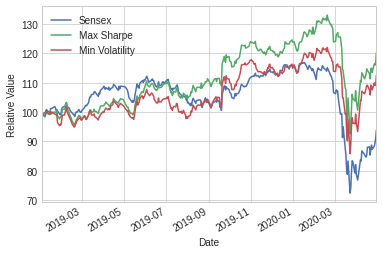

In [0]:
# Plot Relative Performance Graph
plt.style.use('seaborn-whitegrid')
portfolio_performance.plot(grid=True)
plt.ylabel("Relative Value")
plt.show()

In [0]:
# Print LaTeX-friendly portfolio composition

for ticker in sensex30_prices.columns.values:
  print(ticker + ' & ' + 
        (str(round(max_sharpe_nonzero_wts[ticker]*100, 2)) if ticker in max_sharpe_nonzero_wts else 0.00) 
        + '\% & ' 
        + (str(round(min_volatility_nonzero_wts[ticker]*100, 2)) if ticker in min_volatility_nonzero_wts else 0.00)
        + '\% \\\\' )